# Data Description
These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in yyyy-mm-dd format The local time of day in hh:mm:ss 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:  

Solar radiation: watts per meter^2  
Temperature: degrees Fahrenheit  
Humidity: percent  
Barometric pressure: Hg  
Wind direction: degrees  
Wind speed: miles per hour  
Sunrise/sunset: Hawaii time  
link: https://www.kaggle.com/datasets/dronio/SolarEnergy


# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.model_selection import train_test_split
import xgboost as xgb

from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [3]:
data=pd.read_csv('SolarPrediction.csv')

In [4]:
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Wrangling

In [6]:
df=data.copy()

In [7]:
st="9/29/2016 12:00:00 AM"
st.split()

['9/29/2016', '12:00:00', 'AM']

In [8]:
df['Data']=df['Data'].apply(lambda x: x.split()[0])

In [9]:
df['Month']=pd.to_datetime(df['Data']).dt.month

In [10]:
df['Day']=pd.to_datetime(df['Data']).dt.day

df['Hour']=pd.to_datetime(df['Time']).dt.hour
df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second

In [11]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,0,20,4
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,0,15,1
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,0,10,1
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,0,5,2


In [12]:
# '^\d' means that I don't want any digit ('^' this symbol means 'not')
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [13]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int64  
 12  Day                     32686 non-null  int64  
 13  Hour                    32686 non-null  int64  
 14  Minute                  32686 non-null

In [15]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [16]:
df.shape

(32686, 15)

In [17]:
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminuter               0
sethour                   0
setminute                 0
dtype: int64

In [18]:
input_features=df.drop(['Radiation'],axis=1)
target=df['Radiation']

### Feature Selection using correlation matrix
**Note: Dont use this meathod**

In [19]:
corr_matrix=df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


**Don't use heatmap**

<Axes: >

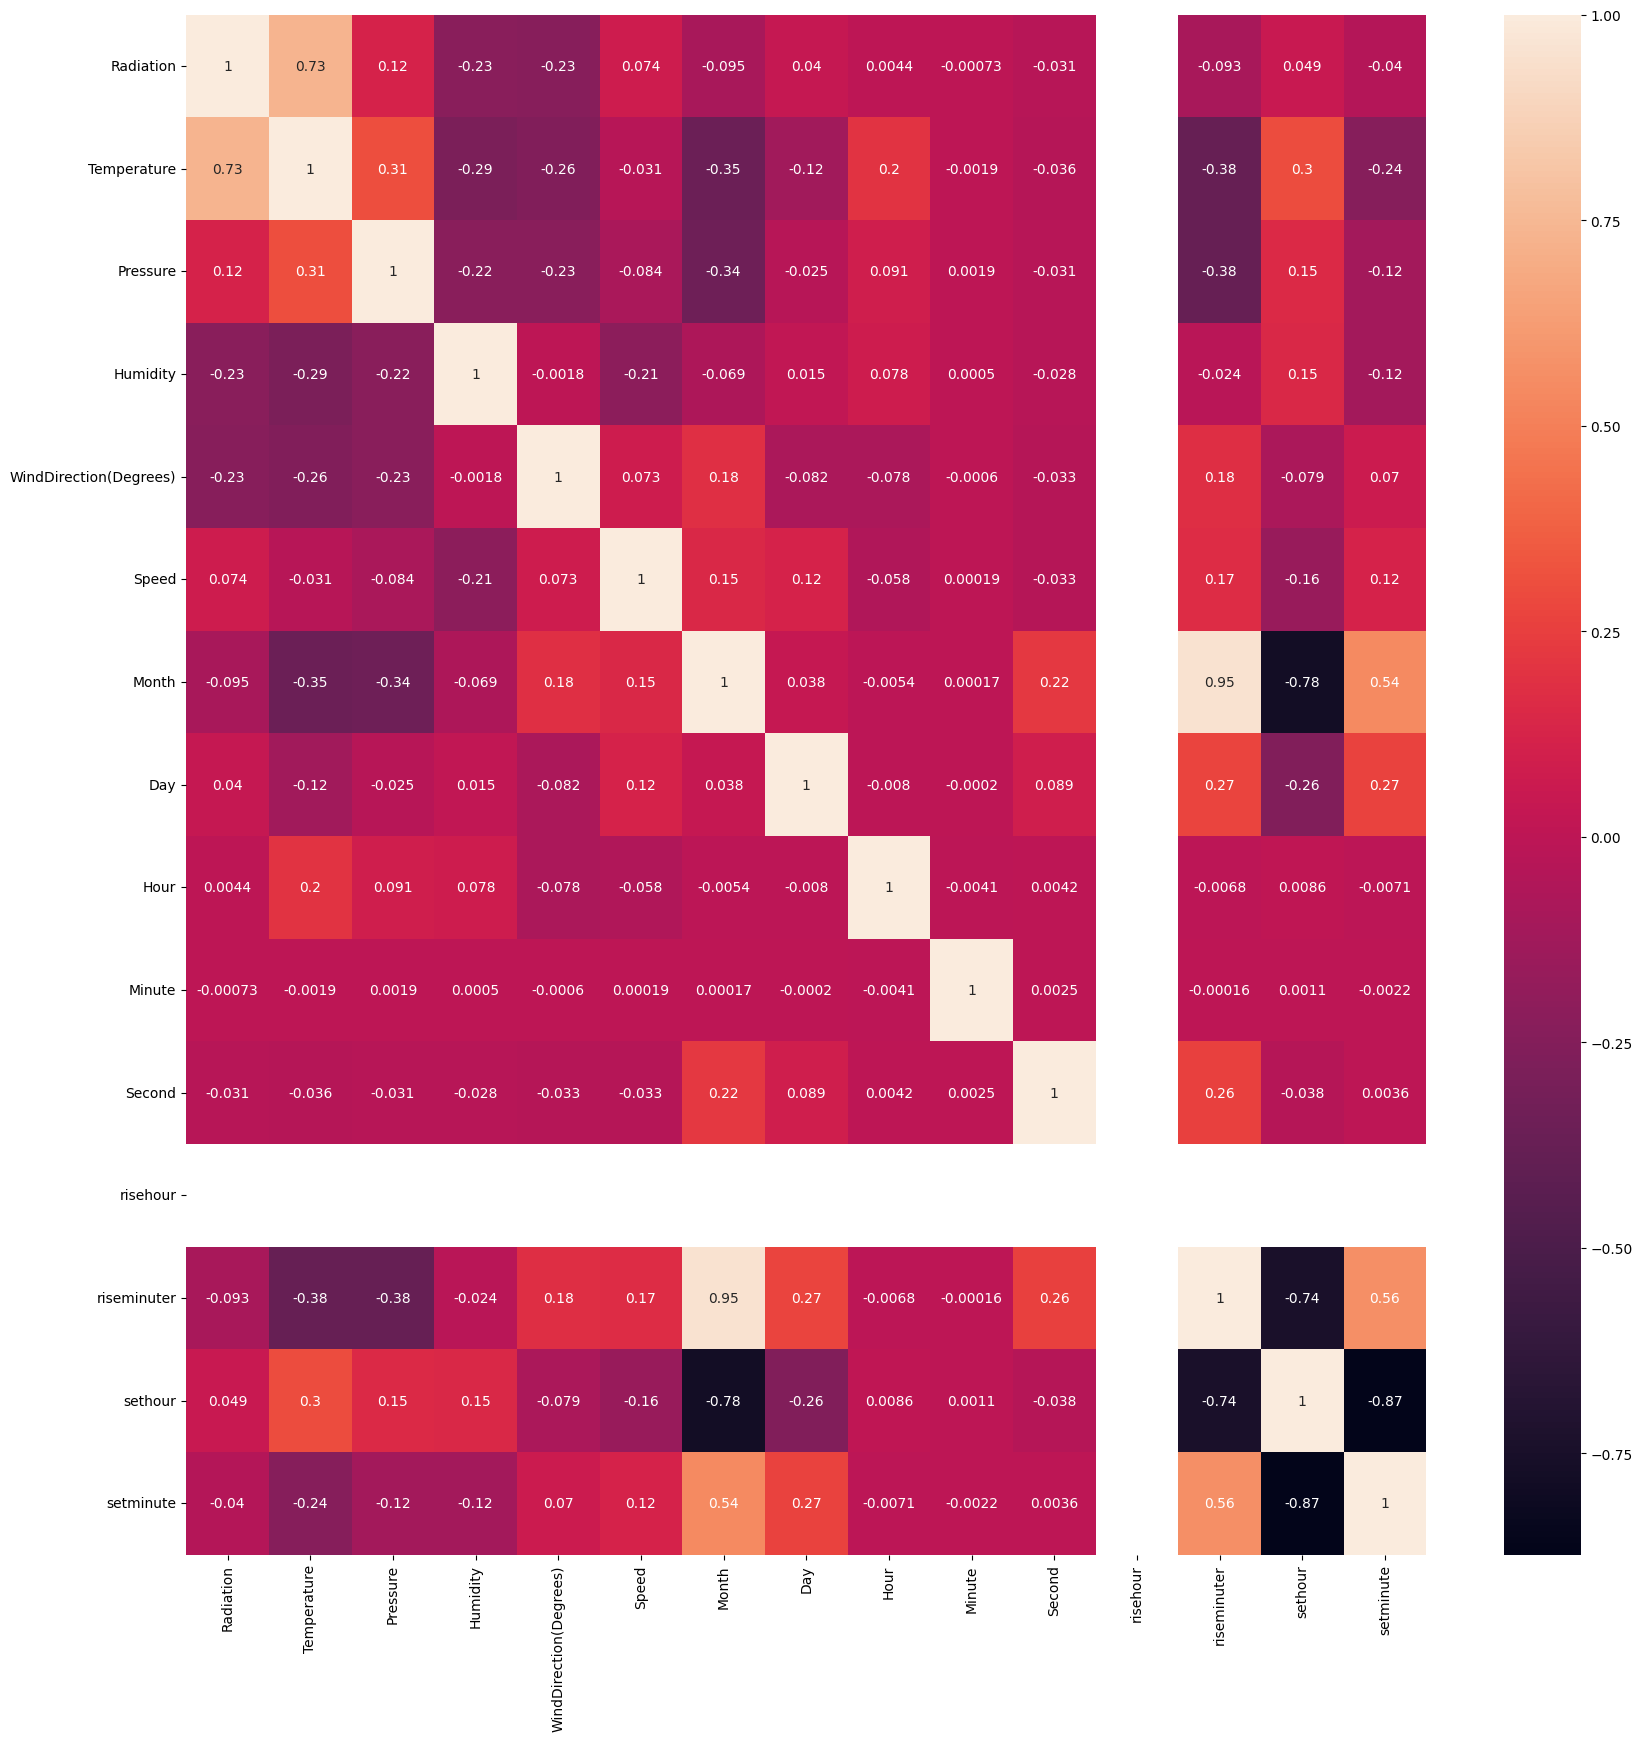

In [20]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,annot=True)

### Feature selection using SelectKBest Meathod

In [21]:
bestfeatures=SelectKBest(score_func=chi2,k=10)

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_y=label_encoder.fit_transform(target)

In [23]:
train_y

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [24]:
target_cont=df['Radiation'].apply(lambda x: int(x*100))

In [25]:
scaled_input_features=MinMaxScaler().fit_transform(input_features)
fit=bestfeatures.fit(scaled_input_features,target_cont)

In [26]:
fit.scores_

array([ 1651.68563214,   523.79106046,  1588.08743322,  3271.82727734,
         765.85977881,  4684.57961042,  2841.92685032,   691.18539264,
        2702.44933263,  2288.67303161,            nan,  4015.06277087,
       12207.53145397,  1863.71208749])

In [27]:
scores=pd.DataFrame(fit.scores_)
column=pd.DataFrame(input_features.columns)

In [28]:
featureScores=pd.concat([column,scores],axis=1)
featureScores.columns=['Features','feature_imp']

In [29]:
featureScores.sort_values(by='feature_imp',ascending=False)

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


# Feature Selection using Using Extra Tree Classifier

In [30]:
model=ExtraTreesClassifier(n_estimators=2,verbose=2)
model.fit(scaled_input_features,target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.0s remaining:    0.0s


building tree 2 of 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.5s finished


ExtraTreesClassifier(n_estimators=2, verbose=2)

In [32]:
feature_importances=pd.DataFrame(model.feature_importances_,index=input_features.columns,columns=['feature_imp'])
feature_importances.sort_values(by='feature_imp',ascending=False,inplace=True)
feature_importances

,feature_imp
WindDirection(Degrees),0.160787
Minute,0.151564
Speed,0.126925
Second,0.125245
Humidity,0.107514
Hour,0.092700
Temperature,0.078471
Pressure,0.077373
Day,0.031632
setminute,0.022853


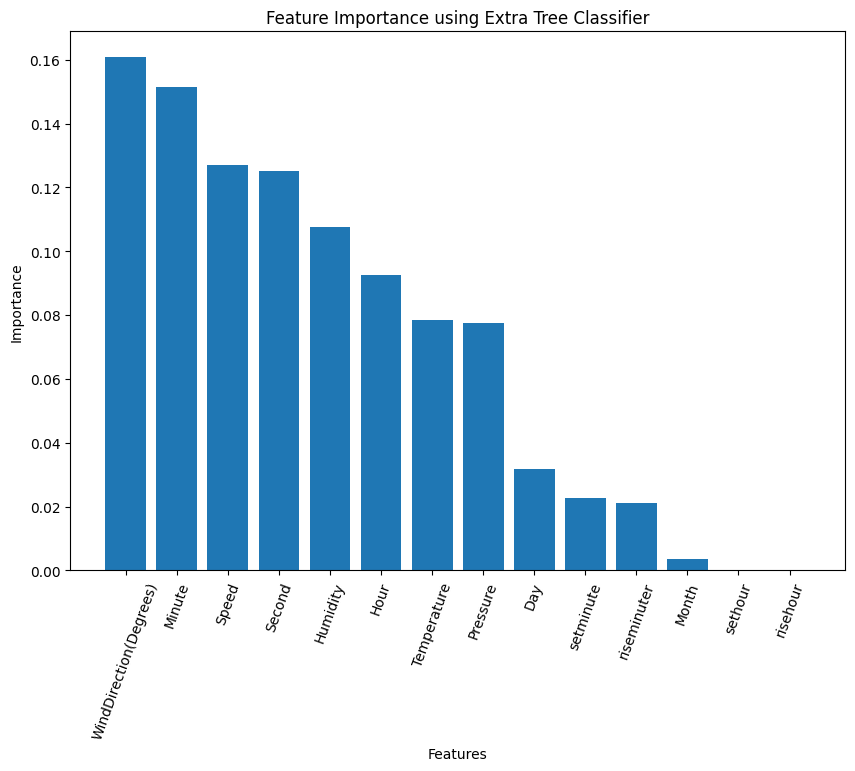

In [33]:
plt.figure(figsize=(10,7))
plt.bar(feature_importances.index,feature_importances['feature_imp'])
plt.xticks(rotation=70)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Extra Tree Classifier')
plt.show()

# Feature Engineering with BoxCox,Log,Min-Max & Standard Transformation

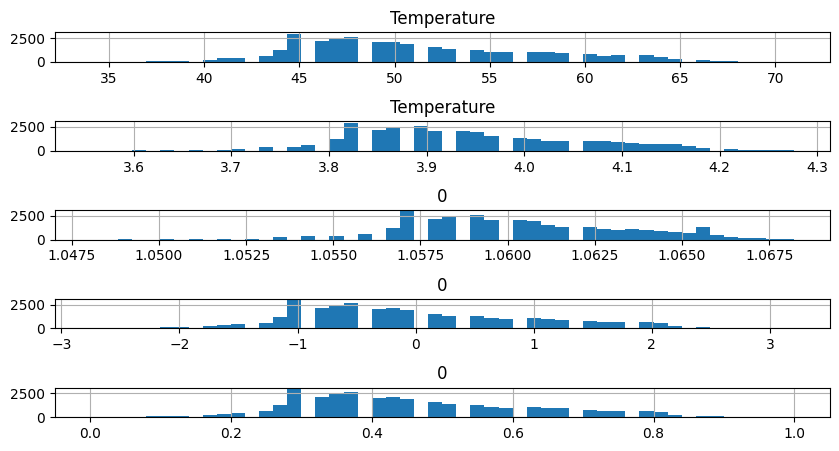

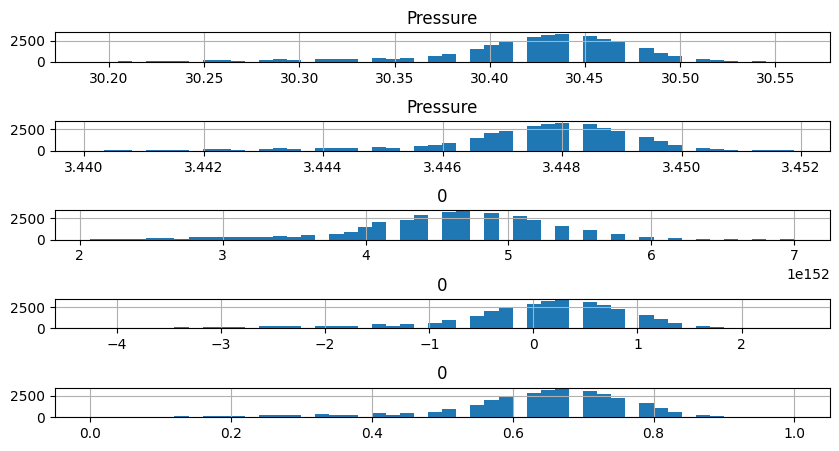

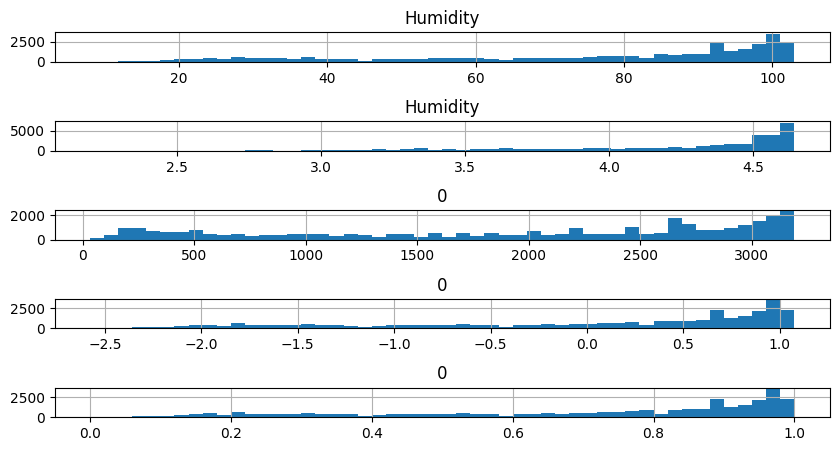

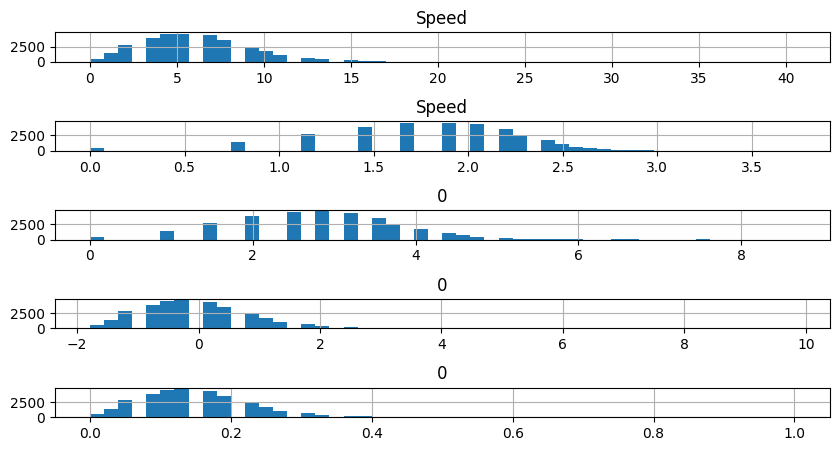

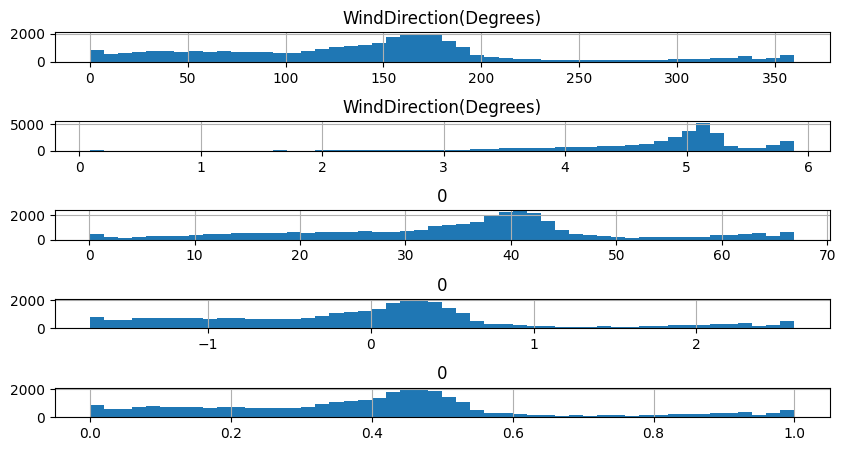

In [37]:
features_to_transform=['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']
for i in features_to_transform:
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1,figsize=(10,5))
    pd.DataFrame(input_features[i]).hist(ax=ax1,bins=50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax4,bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax5,bins=50)
    fig.subplots_adjust(hspace=2)

In [38]:
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [39]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# Preparing data - Standardisation & Splitting

In [43]:
x_train, x_test, y_train, y_test =train_test_split(input_features,target,test_size=0.2,random_state=1)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

# XGBoost Model

In [44]:
from xgboost import XGBRegressor
params={'learning_rate': 0.1,'max_depth':8}
model=XGBRegressor(**params)

In [46]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
y_pred=model.predict(x_test)

In [48]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)

In [49]:
print("Test Performance : ")
print('RMSE : {:.2f}'.format(rmse))
print('R2 : {:.2f}'.format(r2))

Test Performance : 
RMSE : 81.87
R2 : 0.93
